## **CATE (T-learner) example**
- Let's see if we can get more out of an A/B test than just " the treatment is stat-significantly positive."
- Say we're blasting emails at random to users to get them to use a feature more.
    - Do emails work? Maybe.
    - Business: We realized we don't want to blast everyone with emails. Who should we target for future emails?  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [3]:
# distribute some covariates

sample_size = 10000

data = {'income': np.random.randint(1000, size=sample_size),
        'tv' : np.random.choice([0,1], size=sample_size),
        'iphone': np.random.choice([0,1],size=sample_size),
        'new_user': np.random.choice([0,1],size=sample_size),
        'num_days_active_previous_month': np.random.randint(30,size=sample_size),
        'baseline_outcome': np.random.randint(50, size=sample_size),
        'treatment': np.random.choice([0,1], size=sample_size)}

# make latent treatment effect a function of covariates
df = pd.DataFrame(data)

conditions = [ (df['iphone']==0) & (df['new_user']==0) & (df['income']>100) & (df['tv']==0), 
                (df['iphone']==1) & (df['new_user']==1) & (df['income']>500) & (df['tv']==0), 
                (df['iphone']==0) & (df['new_user']==0) & (df['income']>600) & (df['tv']==1),
                (df['iphone']==1) & (df['new_user']==1) & (df['income']>800) & (df['tv']==1),

                  ]
treatments = [ df['baseline_outcome']*1.10, 
                df['baseline_outcome']*1.20, 
                df['baseline_outcome']*1.30,
                df['baseline_outcome']*1.40 ]

treatment_groups = [ 'Tiny Effect', 
                'Small Effect', 
                'Medium Effect',
                'Big Effect' ]

treatment_group_order = [1,2,3,4] 


df["treatment_outcome"] = np.select(conditions, treatments, default=df['baseline_outcome'])
df["treatment_group"] = np.select(conditions, treatment_groups, default='No Effect')
df["treatment_group_order"] = np.select(conditions, treatment_group_order, default=0)

# make observed outcome
df = df.assign(observed_outcome = np.where(df['treatment']==1, df['treatment_outcome'], df['baseline_outcome']))

print('Number of effective treatment units:') 
df[df['baseline_outcome']!=df['treatment_outcome']].shape[0]

Number of effective treatment units:


2505

In [4]:
df.treatment_group.value_counts()

treatment_group
No Effect        7444
Tiny Effect      1136
Small Effect      615
Medium Effect     535
Big Effect        270
Name: count, dtype: int64

In [5]:
# t-test

ols_fit = smf.ols('observed_outcome ~ treatment', data=df).fit()
print(ols_fit.summary())

print(ols_fit.params.iloc[1])
print(ols_fit.bse.iloc[1])

                            OLS Regression Results                            
Dep. Variable:       observed_outcome   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     21.69
Date:                Thu, 03 Oct 2024   Prob (F-statistic):           3.25e-06
Time:                        21:24:42   Log-Likelihood:                -41233.
No. Observations:               10000   AIC:                         8.247e+04
Df Residuals:                    9998   BIC:                         8.249e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     24.6696      0.210    117.591      0.0

## **Fitting and Evaluating T-learner**

* OK... we see that the effect is pretty marginal, not statistically significant if we use the cutoff of 0.05. Let use the T-learner to see if we can get anything more out of this. 
* The below snippet borrows heavily from [Causal Inference for the Brave and True](https://matheusfacure.github.io/python-causality-handbook/21-Meta-Learners.html).

In [6]:
y = "observed_outcome"
T = "treatment"
X = ["income", "tv", "iphone", "new_user", "num_days_active_previous_month", ]

#split into test and train

train = df.sample(frac=.6)
test = df[~df.index.isin(train.index)]
np.random.seed(123)

#m0 = LGBMRegressor(max_depth=2, min_child_samples=60)
#m1 = LGBMRegressor(max_depth=2, min_child_samples=60)

m0 = RandomForestRegressor(max_depth=4)
m1 = RandomForestRegressor(max_depth=4)

m0.fit(train.query(f"{T}==0")[X], train.query(f"{T}==0")[y])
m1.fit(train.query(f"{T}==1")[X], train.query(f"{T}==1")[y])

# estimate the CATE
t_learner_cate_train = m1.predict(train[X]) - m0.predict(train[X])
t_learner_cate_test = test.assign(cate=m1.predict(test[X]) - m0.predict(test[X]))


### **How does the T-learner do in terms of predicting the treatment effect for our groups?**
* We can see how we do and plot against the real outcomes, since we actually know these. 
* As can be seen, we don't do a great job of predicting the value. But are able to predict the order, and often this is what matters most -- we're interested in who will benefit from an intervention the most. 


In [17]:
# true treatment effect
t_learner_cate_test['true_treatment_effect'] = t_learner_cate_test['treatment_outcome'] - t_learner_cate_test['baseline_outcome']
df_eval = t_learner_cate_test[['cate', 'true_treatment_effect', 'treatment_group', 'treatment_group_order']].groupby(['treatment_group']).mean().reset_index().sort_values(by='treatment_group_order')
df_eval

,treatment_group,cate,true_treatment_effect,treatment_group_order
2,No Effect,0.721197,0.000000,0.0
4,Tiny Effect,1.177114,2.563393,1.0
3,Small Effect,2.682849,4.690164,2.0
1,Medium Effect,2.609320,7.919731,3.0
0,Big Effect,3.862254,10.435398,4.0


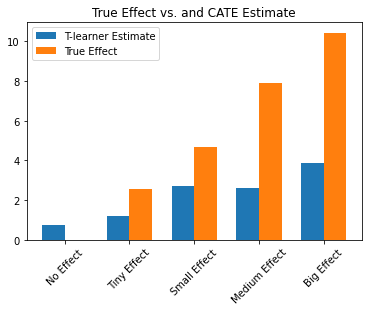

In [25]:
# plot
bar_width = 0.35
x = np.arange(len(df_eval['treatment_group']))
fig, ax = plt.subplots()
ax.bar(x - bar_width / 2, df_eval['cate'], bar_width, label='T-learner Estimate')
ax.bar(x + bar_width / 2, df_eval['true_treatment_effect'], bar_width, label='True Effect')
ax.set_xticks(x)
ax.set_xticklabels(df_eval['treatment_group'], rotation=45)
ax.legend()
plt.title('True Effect vs. and CATE Estimate')
plt.show()
